In [30]:
import torch
import torch.nn as nn
import string
import numpy as np
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from IPython.core.debugger import set_trace
import IPython
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
def get_alphabets_random(window, shift, text=None, reverse=False):
    if text is not None:
        shift = shift % len(text)
        shifted_text = text[shift:] + text[:shift]
        return f'Input: {text}\nShifted: {shifted_text}'
    
    alphabets = string.ascii_lowercase
    rand_indices = [random.randint(0, 25) for _ in range(window)]
    
    text = ''.join(list(map(lambda x: alphabets[x], rand_indices)))
    
    if reverse:
        reversed_text = ''.join(list(reversed(list(text))))
        return text, reversed_text
        
    shift = shift % len(text)
    shifted_text = text[shift:] + text[:shift]
    
    return text, shifted_text

get_alphabets_random(10, -2, reverse=True)

('gkkroqlxtr', 'rtxlqorkkg')

In [16]:
def generate_training_data(window, shift, num_examples, reverse):
    x = list(); y = list()
    
    for _ in range(num_examples):
        text, shifted = get_alphabets_random(window, shift, reverse=reverse)
        x.append(text); y.append(shifted)
        
    random_id = random.randint(0, len(x))
    print(x[random_id], y[random_id])
    
    return x, y

In [17]:
def create_vocabulary():
    unique_characters = list(string.ascii_lowercase)
    char_to_id = {char:i for i, char in enumerate(unique_characters)}
    id_to_char = {i: char for i, char in enumerate(unique_characters)}
    
    features_dim = len(unique_characters)
    print(f'Number of features is {features_dim}')
    return char_to_id, id_to_char, features_dim

In [18]:
encode_text = lambda x: [char_to_id[_] for _ in x]
decode_text = lambda x_: [id_to_char[_] for _ in x_]

In [19]:
def encode_data(x, y, features_dim):
    encoded_x = list(map(lambda x_: encode_text(x_), x))
    encoded_y = list(map(lambda x_: encode_text(x_), y))
    
    one_hot_x = F.one_hot(torch.tensor(encoded_x), num_classes=features_dim)
    one_hot_y = F.one_hot(torch.tensor(encoded_y), num_classes=features_dim)
    
    one_hot_y = one_hot_y.permute(1, 0, 2)
    
    return one_hot_x.to(torch.float32), one_hot_y.to(torch.float32)

In [20]:
x, y = generate_training_data(10, -2, 10000, True)
char_to_id, id_to_char, features = create_vocabulary()
one_hot_x, one_hot_y = encode_data(x, y, features)
print(one_hot_x.dtype, one_hot_y.dtype)

val_x, val_y = generate_training_data(10, -2, 1000, True)
val_x, val_y = encode_data(val_x, val_y, features)
print(val_x.shape, val_y.shape)

mbokrqazub buzaqrkobm
Number of features is 26
torch.float32 torch.float32
yfsnqdwjjz zjjwdqnsfy
torch.Size([1000, 10, 26]) torch.Size([10, 1000, 26])


In [21]:
class CustomData(Dataset):
    def __init__(self, x_data, y_data):
        super().__init__()
        self.x_data = x_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[:, idx, :]
    
dataset = CustomData(one_hot_x, one_hot_y)
val_dataset = CustomData(val_x, val_y)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [22]:
class AttentionModel(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, input_features_dim, output_features_dim, timesteps, num_training):
        super().__init__()
        self.timesteps = timesteps
        self.input_features_dim = input_features_dim
        
        self.densor1 = nn.Linear(decoder_dim+(2*encoder_dim), 10)
        self.tanh = nn.Tanh()
        self.densor2 = nn.Linear(10, 1)
        self.softmax = nn.Softmax(dim=1)
        
        self.pre_attention_lstm = nn.LSTM(input_size=input_features_dim, hidden_size=encoder_dim, batch_first=True, bidirectional=True)
        self.post_attention_lstm = nn.LSTM(input_size=encoder_dim*2, hidden_size=decoder_dim, batch_first=True)
        self.output_layer = nn.Linear(decoder_dim, output_features_dim)
        
        
    def forward(self, x, s0, c0):
        # x-> (B, timesteps, features) -> (128, 10, 26)
        # s0, c0 -> (1, B, decoder_dim) -> (1, 128, 16)
        #set_trace()
        self.s = s0; self.c = c0
        encoder_hidden_states, (hn, cn) = self.pre_attention_lstm(x) #hidden_states: (B, timesteps, encoder_dim*2) -> (128, 10, 16)
        outputs = list()
        
        for t in range(self.timesteps):
            context = self.one_step_attention(encoder_hidden_states) # (B, timesteps, 2*encoder_dim)
            _, (self.s, self.c )= self.post_attention_lstm(context, (self.s, self.c)) # _ -> (B, timesteps, decoder_dim)
            output = self.output_layer(self.s) # (1, B, output_features_dim) -> (1, 128, 26)
            outputs.append(output) # (timesteps, B, output_features_dim) -> (10, 128, 26)
        
        return outputs
    
    def one_step_attention(self, encoder_hidden_states):
        # encoder_Hidden_states -> (B, timesteps, 2*encoder_dim) -> (128, 10, 16)
        # self.s -> (1, B, decoder_dim)
        # 1. first the hidden state for decoder must be repeated to match the hidden states of encoder
        # self.s -> (timesteps, B, decoder_dim) -> permute -> (B, timesteps, decoder_dim)
        # 2. then concatenate the hidden state for decoder and the hidden state for encoder -> (B, timesteps, 2*encoder_dim + decoder_dim)
        # pass it through the first dense layer
        # pass it through the second dense layer
        # use softmax to decide which hidden state of encoder is the most important
        # use dot product to find the important hidden state of encoder and feed it as input to the decoder
        hidden_decoder = self.s.repeat(10, 1, 1).permute(1, 0, 2) # (B, timesteps, decoder_dim) -> (128, 10, 16)
        concat = torch.concatenate([encoder_hidden_states, hidden_decoder], dim=-1) # (B, timesteps, 2*encoder_dim + decoder_dim) -> (128, 10, 32)
        e = self.tanh(self.densor1(concat)) # (B, timesteps, 10) -> (128, 10, 10)
        energies = self.softmax(self.densor2(e)) # (B, timesteps, 1) -> (128, 10, 1)
        # let's if without permute in next step if the code converges
        energies = energies.repeat(1, 1, 10).permute(0, 2, 1) # (B, timesteps, 10) -> (B, 10, 10)
        context = torch.bmm(energies, encoder_hidden_states) # (B, timesteps, timesteps) @ (B, timesteps, 2*encoder_dim) -> (B, timesteps, 2*encoder_dim)
        
        return context
        
    def predict(self, x):
        assert len(x) == self.timesteps
        encoded = encode_text(x)
        one_hot = F.one_hot(torch.tensor(encoded), num_classes=self.input_features_dim)
        s0 = torch.zeros(1, 1, decoder_dim); c0 = torch.zeros(1, 1, decoder_dim)
        one_hot = one_hot.unsqueeze(0)
        pred = self.forward(one_hot.to(torch.float32), s0, c0)
        pred = ''.join(decode_text([torch.argmax(t, dim=-1).tolist()[0][0] for t in pred]))
        return pred

In [23]:
def calculate_loss(y_true, y_pred):
    ce = nn.CrossEntropyLoss()
    total = 0
    for target, logit in zip(list(y_true), list(y_pred)):
        loss = ce(logit[0], target)
        total += loss
        
    return total

In [24]:
imp = list()

def hook_function(module, input, output):
    if not am.training:
        imp.append(output[0].flatten().tolist())

In [25]:
encoder_dim = 8
decoder_dim = 16
input_features_dim = features
output_features_dim = features
timesteps = 10
num_training = 10000
epochs = 40

attention_dict = dict()

s0, c0 = torch.zeros(1, num_training, decoder_dim), torch.zeros(1, num_training, decoder_dim)

am = AttentionModel(encoder_dim, decoder_dim, input_features_dim, output_features_dim, timesteps, num_training)
opt = optim.Adam(am.parameters())

In [26]:
for name, layer in am.named_children():
    if name == 'softmax':
        print(layer)
        handle = layer.register_forward_hook(hook_function)

Softmax(dim=1)


In [27]:
for epoch in range(epochs):
    am.train()
    train_loss = list()
    for i, (inputs, target) in enumerate(train_loader):
        #set_trace()
        target = target.permute(1, 0, 2)
        batch_size = inputs.size(0)
        s0 = torch.zeros(1, batch_size, decoder_dim); c0 = torch.zeros(1, batch_size, decoder_dim)
        outputs = am(inputs, s0, c0)
        
        opt.zero_grad()
        
        total_loss = calculate_loss(target, outputs)
        train_loss.append(total_loss)
        
        total_loss.backward()
        opt.step()
        
    print(f'Epoch {epoch}:: Train Loss {torch.mean(torch.tensor(train_loss))}')
    
    am.eval()
    with torch.no_grad():
#         s0 = torch.zeros(1, 1000, decoder_dim); c0 = torch.zeros(1, 1000, decoder_dim)
#         out = am(val_x, s0, c0)
        
#         val_loss = calculate_loss(val_y, out)
        
#         print(f'Epoch {epoch}:: Val Loss {val_loss}')
        test = 'monojitcnn'
        pred = am.predict(test)
        print(f'Input {test} --> Output {pred}')
        
        attention_dict[f'Epoch {epoch}'] = np.array(imp)
        imp = list()
        print()
    

Epoch 0:: Train Loss 32.56444549560547
Input monojitcnn --> Output aaaaaaaaaa

Epoch 1:: Train Loss 31.95025634765625
Input monojitcnn --> Output dddddddddd

Epoch 2:: Train Loss 31.396120071411133
Input monojitcnn --> Output dddddddddd

Epoch 3:: Train Loss 30.901729583740234
Input monojitcnn --> Output nddddddddd

Epoch 4:: Train Loss 30.532001495361328
Input monojitcnn --> Output nccccccccc

Epoch 5:: Train Loss 29.835437774658203
Input monojitcnn --> Output dcccceeeee

Epoch 6:: Train Loss 28.65953254699707
Input monojitcnn --> Output nnnccfffff

Epoch 7:: Train Loss 26.70486831665039
Input monojitcnn --> Output nncceemmmm

Epoch 8:: Train Loss 23.72628402709961
Input monojitcnn --> Output nncbbommmm

Epoch 9:: Train Loss 20.463516235351562
Input monojitcnn --> Output nncbeoemmm

Epoch 10:: Train Loss 17.198877334594727
Input monojitcnn --> Output nnccioemmm

Epoch 11:: Train Loss 14.16718578338623
Input monojitcnn --> Output nnccijommm

Epoch 12:: Train Loss 11.6624755859375
Input

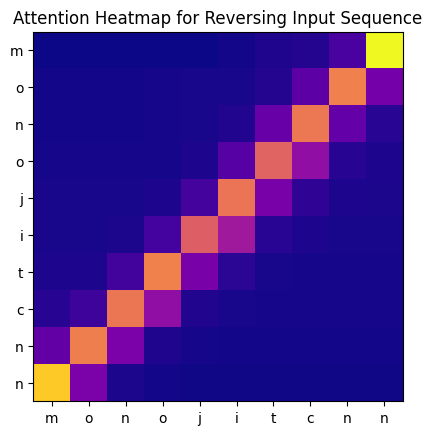

In [47]:
plt.imshow(attention_dict['Epoch 39'], cmap='plasma')
plt.title('Attention Heatmap for Reversing Input Sequence')
plt.xticks(range(len(test)), labels=test)
plt.yticks(range(len(test)), labels=test)
plt.show()

In [48]:
for key in attention_dict:
    plt.imshow(attention_dict[key], cmap='plasma')
    plt.title(key)
    plt.title('Attention Heatmap for Reversing Input Sequence')
    plt.xticks(range(len(test)), labels=test)
    plt.yticks(range(len(test)), labels=test)
    plt.colorbar()
    
    file_name = f'{key}.png'
    plt.savefig(f'/kaggle/working/{file_name}')
    plt.close()

In [50]:
frames = list()

for key in attention_dict:
    img = Image.open(f'/kaggle/working/{key}.png')
    img = img.convert('RGB')
    
    frames.append(img)
    
frames[0].save('reverse_animation.gif', save_all=True, append_images=frames[1:], duration=150, loop=0)

In [32]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight